In [31]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [32]:
actions = [
    '1',
    '2',
    '3',
    '4',
    '5',
]

data = np.concatenate([
    np.load('dataset/seq_1_1689498638.npy'),
    np.load('dataset/seq_2_1689498638.npy'),
    np.load('dataset/seq_3_1689498638.npy'),
    np.load('dataset/seq_4_1689498638.npy'),
    np.load('dataset/seq_5_1689498638.npy')
], axis=0)

data.shape

(1240, 30, 100)

In [33]:
#마지막에 label 데이터가 저장되어 있기 때문에 -1을 해준다.
x_data = data[:, :, : -1]
#마지막 값만 라벨에 저장
labels = data[:,0, -1]

print(x_data.shape)
print(labels.shape)

(1240, 30, 99)
(1240,)


In [34]:
from tensorflow.keras.utils import to_categorical
#라벨을 카데코리 데이터로 만들어 주어야한다. one hot encoding
y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(1240, 5)

In [35]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)
# 0.9는 training data 0.1은 validation data
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(1116, 30, 99) (1116, 5)
(124, 30, 99) (124, 5)


In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

#모델을 만들어 주어야함 sequential api사용
model = Sequential([
    #LSTM과 Dense를 연결해 주어야한다.
    #shape는 1:3인데 윈도우 사이즈와 랜드마크, 각도, 비저빌리티가 된다.
    LSTM(64, activation='softmax', input_shape=x_train.shape[1:3]),
    Dense(32, activation='softmax'),
    Dense(len(actions), activation='softmax')
])
#3개의 액션중에 무엇인가 5개중에 추론하도록함
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                41984     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 5)                 165       
                                                                 
Total params: 44229 (172.77 KB)
Trainable params: 44229 (172.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.summary()

In [37]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    #200번 에폭을 돈다.
    epochs=200,
    
    callbacks=[
        #모델을 저정하고 러닝메이트를 조절한다.
        ModelCheckpoint('models/model_num.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
31/35 [=========================>....] - ETA: 0s - loss: 131.9480 - acc: 0.2016
Epoch 1: val_acc improved from -inf to 0.22581, saving model to models/model_num.h5
35/35 [==============================] - 1s 12ms/step - loss: 126.2880 - acc: 0.1989 - val_loss: 57.0553 - val_acc: 0.2258 - lr: 0.0010
Epoch 2/200
23/35 [==================>...........] - ETA: 0s - loss: 51.6886 - acc: 0.2758

/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/35 [=========================>....] - ETA: 0s - loss: 61.4684 - acc: 0.2681
Epoch 2: val_acc did not improve from 0.22581
35/35 [==============================] - 0s 8ms/step - loss: 64.1712 - acc: 0.2608 - val_loss: 77.7470 - val_acc: 0.2097 - lr: 0.0010
Epoch 3/200
34/35 [============================>.] - ETA: 0s - loss: 27.1649 - acc: 0.3244
Epoch 3: val_acc improved from 0.22581 to 0.45161, saving model to models/model_num.h5
35/35 [==============================] - 0s 9ms/step - loss: 26.7754 - acc: 0.3289 - val_loss: 11.5768 - val_acc: 0.4516 - lr: 0.0010
Epoch 4/200
35/35 [==============================] - ETA: 0s - loss: 13.3706 - acc: 0.4337
Epoch 4: val_acc improved from 0.45161 to 0.50000, saving model to models/model_num.h5
35/35 [==============================] - 0s 9ms/step - loss: 13.3706 - acc: 0.4337 - val_loss: 12.7876 - val_acc: 0.5000 - lr: 0.0010
Epoch 5/200
34/35 [============================>.] - ETA: 0s - loss: 11.8678 - acc: 0.4752
Epoch 5: val_acc improved 

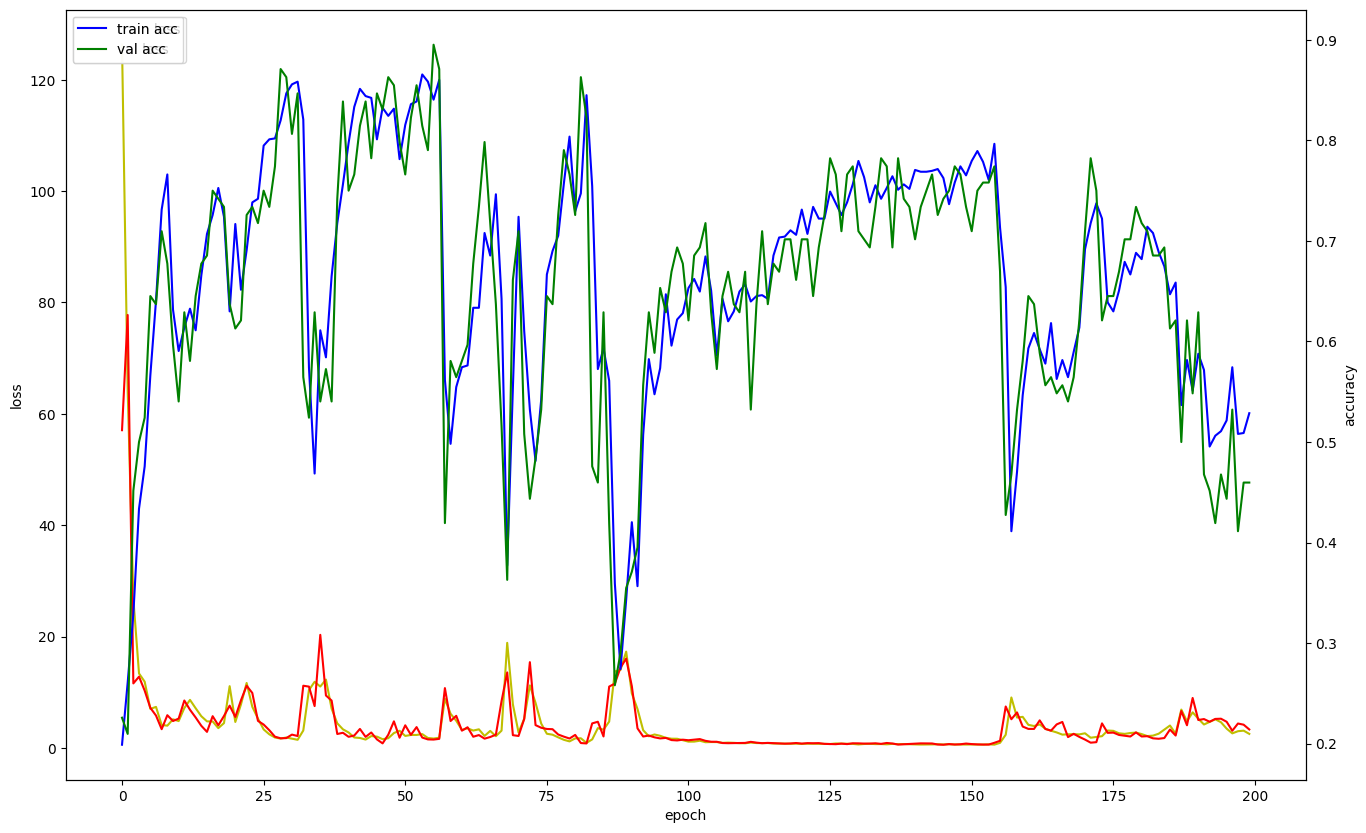

In [38]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [39]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

4/4 [==============================] - 0s 2ms/step


array([[[101,   1],
        [ 12,  10]],

       [[ 91,   7],
        [ 21,   5]],

       [[ 45,  53],
        [  9,  17]],

       [[101,   1],
        [ 12,  10]],

       [[ 87,   9],
        [ 17,  11]]])